In [1]:
## For data handling
import pandas as pd
import numpy as np

## For plotting
import matplotlib.pyplot as plt
from seaborn import set_style

## This sets the plot style
## to have a grid on a white background
set_style("darkgrid")

In [15]:
X = np.load('../../data/processed_data/specgram_db_pad_trunc.npy')
print(X.shape)

(440, 128, 67)


In [16]:
# NEW to CONV nets
## We need to reshape our data to be the correct dimensions for
## the net
## observations, grid, colorvalues

##so we just need to add the colorvalues, 1 here represents single valued
X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)
print(X.shape)

(440, 128, 67, 1)


In [17]:
df = pd.read_csv("../../data/processed_data/metadata.csv")
category_to_number = {'brushing': 0, 'food': 1, 'isolation': 2}

# Create a new column with numerical values based on the mapping
df['numerical_situation'] = df['situation'].map(category_to_number)

y = df['numerical_situation']


In [18]:
df

,Unnamed: 0,filename,situation,sex,breed,numerical_situation
0,0,F_MAG01_EU_FN_FED01_106.wav,food,0,european_shorthair,1
1,1,I_NUL01_MC_MI_SIM01_304.wav,isolation,1,maine_coon,2
2,2,I_MEG01_MC_FI_SIM01_304.wav,isolation,0,maine_coon,2
3,3,B_CAN01_EU_FN_GIA01_205.wav,brushing,0,european_shorthair,0
4,4,F_MAG01_EU_FN_FED01_304.wav,food,0,european_shorthair,1
...,...,...,...,...,...,...
435,435,I_TIG01_EU_FN_GIU01_201.wav,isolation,0,european_shorthair,2
436,436,B_NIG01_MC_MN_SIM01_101.wav,brushing,1,maine_coon,0
437,437,B_CAN01_EU_FN_GIA01_208.wav,brushing,0,european_shorthair,0
438,438,B_WHO01_MC_FI_SIM01_203.wav,brushing,0,maine_coon,0


In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                       test_size=.2,
                                                       shuffle=True,
                                                       random_state=100,
                                                       stratify=y)

In [20]:
X_train_train, X_val, y_train_train, y_val = train_test_split(X_train, y_train,
                                                                 test_size=.2,
                                                                   shuffle=True,
                                                                   random_state=41,
                                                                   stratify=y_train)

In [25]:
## Importing the things
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import metrics
from tensorflow.keras.utils import to_categorical

# for earlier versions of keras run this instead
# from keras.utils import to_categorical
# instead of running
# from keras.utils.np_utils import to_categorical
# or look up the documentation for your version

In [26]:
## We've seen this before
model = models.Sequential()

In [27]:
## adding our first convolutional layer

## Conv2D(32, specifies that we want a convolutional layer with depth 32
## (3,3) is our sliding grid size
## We're using the relu activation function
## and our images are a gray scale value for 28X28 pixels, hence the input_shape
model.add( layers.Conv2D(32, (6,3), activation='relu', input_shape=(X.shape[1],X.shape[2],1,) ) )


## adding our first Max Pooling layer
## MaxPooling2D((2,2) tells python we want to add
## a max pooling layer that uses a (2,2) square grid
## strides = 2, sets the stride value to 2
model.add( layers.MaxPooling2D( (2,2), strides = 2 ) )


## Add another layer, alternating between conv and pool
model.add( layers.Conv2D(64, (6,3), activation='relu'))
model.add( layers.MaxPooling2D( (2,2), strides=2) )



In [28]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 123, 65, 32)       608       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 61, 32, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 56, 30, 64)        36928     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 28, 15, 64)        0         
 g2D)                                                            
                                                                 
Total params: 37536 (146.62 KB)
Trainable params: 37536 (146.62 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [29]:
## Now we'll add the fully connected layer

## .Flatten() will flatten the data for us,
## meaning the last output data will turn into 
## a vector
model.add( layers.Flatten() )

## We've seen these before
## Then we add a single dense hidden layer
## This is 64 nodes high
model.add(layers.Dense(64, activation='relu'))


## Finally an output layer
model.add(layers.Dense(3, activation='softmax'))

In [30]:
## We've seen this before in the last notebook
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [31]:
## we'll go for 10 epochs
## This is slow!
epochs=100
history = model.fit(X_train_train, 
                      to_categorical(y_train_train), 
                      epochs=epochs, 
                      batch_size=512,
                      validation_data=(X_val,to_categorical(y_val)))

Epoch 1/100
1/1 [==============================] - 1s 883ms/step - loss: 4.6450 - accuracy: 0.5018 - val_loss: 580.2137 - val_accuracy: 0.2113
Epoch 2/100
1/1 [==============================] - 1s 557ms/step - loss: 571.7913 - accuracy: 0.2100 - val_loss: 163.1123 - val_accuracy: 0.2817
Epoch 3/100
1/1 [==============================] - 1s 569ms/step - loss: 162.3568 - accuracy: 0.2883 - val_loss: 20.2747 - val_accuracy: 0.2817
Epoch 4/100
1/1 [==============================] - 1s 557ms/step - loss: 20.1834 - accuracy: 0.2883 - val_loss: 8.3119 - val_accuracy: 0.2113
Epoch 5/100
1/1 [==============================] - 1s 552ms/step - loss: 8.2560 - accuracy: 0.2100 - val_loss: 7.2200 - val_accuracy: 0.2817
Epoch 6/100
1/1 [==============================] - 1s 588ms/step - loss: 7.2279 - accuracy: 0.2883 - val_loss: 1.2277 - val_accuracy: 0.2817
Epoch 7/100
1/1 [==============================] - 1s 582ms/step - loss: 1.2346 - accuracy: 0.2847 - val_loss: 1.1493 - val_accuracy: 0.2817
Epo

Epoch 59/100
1/1 [==============================] - 1s 576ms/step - loss: 0.0433 - accuracy: 0.9964 - val_loss: 1.0743 - val_accuracy: 0.7606
Epoch 60/100
1/1 [==============================] - 1s 590ms/step - loss: 0.0412 - accuracy: 0.9929 - val_loss: 1.1016 - val_accuracy: 0.7465
Epoch 61/100
1/1 [==============================] - 1s 595ms/step - loss: 0.0462 - accuracy: 0.9964 - val_loss: 1.0974 - val_accuracy: 0.7746
Epoch 62/100
1/1 [==============================] - 1s 620ms/step - loss: 0.0359 - accuracy: 0.9929 - val_loss: 1.1975 - val_accuracy: 0.7183
Epoch 63/100
1/1 [==============================] - 1s 694ms/step - loss: 0.0398 - accuracy: 0.9964 - val_loss: 1.1208 - val_accuracy: 0.7887
Epoch 64/100
1/1 [==============================] - 1s 597ms/step - loss: 0.0301 - accuracy: 0.9929 - val_loss: 1.2261 - val_accuracy: 0.7183
Epoch 65/100
1/1 [==============================] - 1s 564ms/step - loss: 0.0271 - accuracy: 0.9964 - val_loss: 1.1503 - val_accuracy: 0.7746
Epoch 

In [32]:
history_dict = history.history

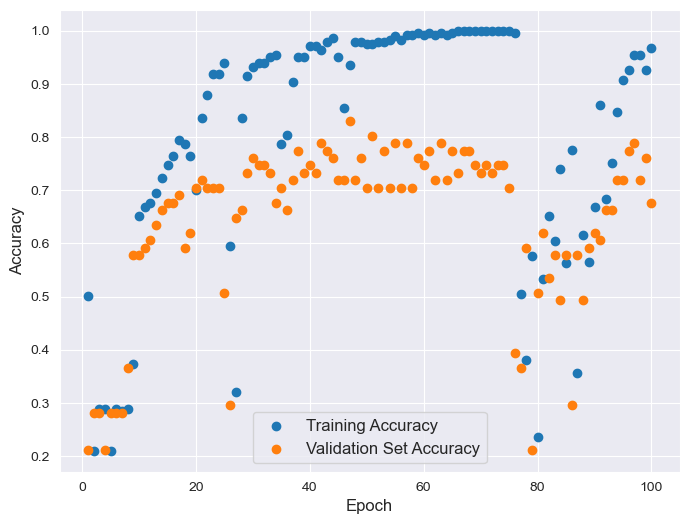

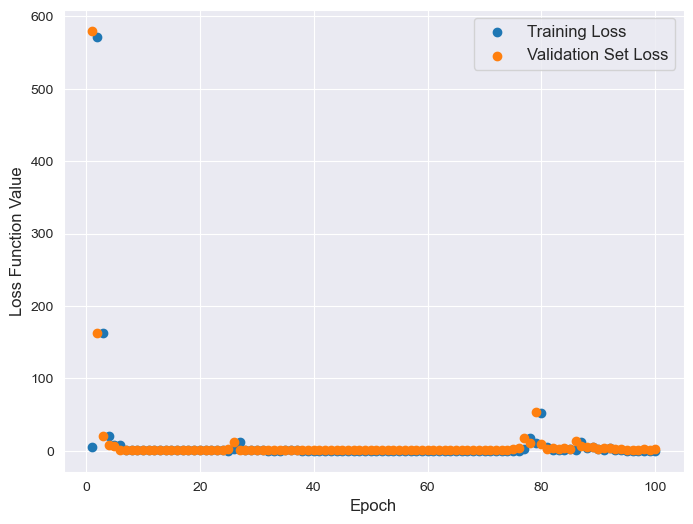

In [33]:
plt.figure(figsize = (8,6))

plt.scatter(range(1,epochs+1), history_dict['accuracy'], label = "Training Accuracy")
plt.scatter(range(1,epochs+1), history_dict['val_accuracy'], label = "Validation Set Accuracy")

plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.legend(fontsize=12)

plt.show()


plt.figure(figsize = (8,6))

plt.scatter(range(1,epochs+1), history_dict['loss'], label = "Training Loss")
plt.scatter(range(1,epochs+1), history_dict['val_loss'], label = "Validation Set Loss")

plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss Function Value", fontsize=12)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.legend(fontsize=12)

plt.show()